In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import numpy as np


for mod in ["sutton_functions"]:
    if mod in sys.modules:
            del sys.modules[mod]
            
from sutton_functions import *

CPU times: user 1.03 s, sys: 1.68 s, total: 2.71 s
Wall time: 410 ms


In [2]:

def vapor_concentration_RH( T, RH = 100):
    """
    Calculate the vapor concentration (in g/m³) for a given relative humidity (RH) and temperature (T in °C).
    
    Parameters:
    - RH (float): Relative humidity as a fraction (e.g., 0.5 for 50%).
    - T (float): Temperature in degrees Celsius.
    
    Returns:
    - float: Vapor concentration in g/m³.
    """
    # Constants
    M_w = 18.015  # molar mass of water vapor in g/mol
    R = 8.314  # universal gas constant in J/(mol*K)
    
    # Calculate the saturation vapor pressure (Pa)
    e_s = 6.1094 * math.exp((17.625 * T) / (T + 243.04))*100

    # Actual vapor pressure (Pa)
    e = RH/100 * e_s
    
    # Vapor concentration (g/m³)
    C = (e * M_w) / (R * (T + 273.15))
    
    return C


def vapor_concentration(es, T):
    # Constants
    M = 18.015  # Molar mass of water in g/mol
    R = 8.314  # Universal gas constant in J/(mol·K)
    
    # Water vapor concentration calculation
    rho = (es * M) / (R * T)
    return rho


In [3]:


def get_params(fallow_fraction = 0.5, fallow_length = 200, T_c = 30, T_f = 50):
    
    zom = 0.22
    # Flat parameter dictionary
    params = {
        "k": 0.4,           # von Karman constant        
        "zom": zom,         # Momentum roughness length (m)

        "Hmax": 100,        # Maximum height

        "fallow_fraction": fallow_fraction,
        "fallow_length" : fallow_length,
        "dz": 0.5,
        "dx": 5,
        
        'T_c' : T_c,  # Cultivated temperature
        'T_f' : T_f,  # Fallow temperature

    }
    Ubar_10 = 4
    ustar = 0.4*Ubar_10/np.log(10/zom)    # Friction velocity (m/s)
    
    params['xmin'] = 0
    params['ustar'] = ustar
    
    params['zmin'] = params['zom']
    params['zmax'] = params['Hmax']
    params['patch_size'] = int(params['fallow_length']/params['dx'])

    if (fallow_fraction) == 0:
        params['gap_size'] = 1000
        params['patch_size'] = 0
    else:
        params['gap_size'] = int(params['patch_size']*(1- fallow_fraction)/fallow_fraction)
            
    # print(params['patch_size'], params['gap_size'], params['patch_size']/(params['patch_size'] + params['gap_size']))
    Lx = (params['patch_size'] + params['gap_size'])*params['dx']*10
    params['Lx'] = Lx
    params['xmax'] = params['Lx']
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
    nz = len(z)
    x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])
    nx = len(x)   

    RH_c = 42
    es_c = saturation_vapor_pressure(T_c + 273.15)
    Q_c = vapor_concentration_RH(T_c, RH_c)
    Q_s = Q_c

    #     print(f"Cultivated \nSaturation vapor pressure at {T_c}°C is {es_c:.2f} Pa")
    #     print(f"Water vapor concentration at {T_c}°C is {Q_c:.2f} g/m³")

    RH_f = 12
    RH_a = 11.5    
    es_f = saturation_vapor_pressure(T_f + 273.15)
    Q_f = vapor_concentration_RH(T_f, RH_f)
    Q_a  = vapor_concentration_RH(T_f, RH_a)

    #     print(f"Fallow \nSaturation vapor pressure at {T_f}°C is {es_f:.2f} Pa")
    #     print(f"Water vapor concentration at {T_f}°C is {Q_f:.2f} g/m³")

    params['Q_c'] =  Q_c   # Surface water vapor concentration for vegetated areas
    params['Q_f'] =  Q_f   # Surface water vapor concentration for fallowed areas        
    params['Q_a'] =  Q_a   # Upwind background atmospheric water vapor concentration for fallow areas
    params['nx'] = nx
    params['nz'] =  nz    
            
    return params


In [4]:
import numpy as np


def populate_Qc_array(params):
    """
    Retrieve parameters from the dictionary
    """
    x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])
    nx = len(x)
    patch_size = params["patch_size"]
    gap_size = params["gap_size"]
    Q_c = params["Q_c"]
    Q_f = params["Q_f"]
    
    # Initialize the array with zeros or any other default value
    Q_c_array = [Q_f] * (nx)
    
    # Populate the array with alternating patches
    i = 0
   
    while i < nx :
        # Assign a vegetated patch of fixed length
        Q_c_array[i:i +  gap_size ] = [Q_c] * min(gap_size , nx  - i)
        i += patch_size + gap_size
    
    Q_c_array = np.array(Q_c_array) 
    
    #print (params['fallow_fraction'], (Q_c_array == Q_f).mean())
    return np.array(Q_c_array)


def varying_Qs(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Qs_array, Q_a):
    
    # Setup coefficients for the implicit scheme
    A = k * z * ustar
    B = 1.0 / U
    C = our_central_difference(A, dz)

    # Initialize upwind water vapor concentrations and fluxes
    Q1 = Qup_f
    Q = np.zeros((nx, nz))
    Q[0, :] = Q1
    FluxQ = np.zeros((nx, nz))

    # Perform downwind calculations by marching along x
    for i, Qs_i in enumerate(Qs_array):
        Q2, Fq = integrate_H2O_implicit(nx, nz, dx, dz, A, B, C, Q1, Qs_i, Q_a)
        Q[i , :] = Q2
        FluxQ[i , :] = Fq
        Q1 = Q2

    return Q, FluxQ

def uniform_cultivated(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Q_c, Q_a):

    # Setup coefficients for implicit scheme
    A = k * z * ustar
    B = 1.0 / U
    C = our_central_difference(A, dz)

    # Upwind wv concentrations and fluxes
    Q1 = Qup_f
    Q_uniform = np.zeros((nx , nz))
    Q_uniform[0, :] = Q1
    FluxQ_uniform = np.zeros((nx , nz))

    # Begin downwind calculations by marching along x
    for i in range(nx):
        Q2, Fq = integrate_H2O_implicit(nx, nz, dx, dz, A, B, C, Q1, Q_c, Q_a)
        Q_uniform[i, :] = Q2
        FluxQ_uniform[i, :] = Fq
        Q1 = Q2

    return Q_uniform, FluxQ_uniform

def uniform_fallow(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Q_f, Q_a):
    
    # Setup coefficients for implicit scheme
    A = k * z * ustar
    B = 1.0 / U
    C = our_central_difference(A, dz)

    # Upwind wv concentrations and fluxes
    Q1 = Qup_f
    Q_fallow = np.zeros((nx , nz))
    Q_fallow[0, :] = Q1
    FluxQ_fallow = np.zeros((nx , nz))

    # Begin downwind calculations by marching along x
    for i in range(nx):
        Q2, Fq = integrate_H2O_implicit(nx, nz, dx, dz, A, B, C, Q1, Q_f, Q_a)
        Q_fallow[i, :] = Q2
        FluxQ_fallow[i, :] = Fq
        Q1 = Q2

    return Q_fallow, FluxQ_fallow

def ET_enhance(FluxQ_uniform, FluxQ_fallow, FluxQ, params):
    zlevel = 3
    Qs_array = populate_Qc_array(params)
    dx = params['dx']
    nx = params['nx']
    Q_f = params['Q_f']
    Q_c = params['Q_c']    
 
    continuous_cultivation = FluxQ_uniform[-1, zlevel]
    
    uniform_flux = FluxQ_uniform[-1, zlevel]*(Qs_array > Q_f).mean() + \
                FluxQ_fallow[-1, zlevel]*(Qs_array == Q_f).mean()
    uniform_flux = uniform_flux

    FluxQ[Qs_array < Q_c] = FluxQ_fallow[-1,zlevel]
    patchy_flux = FluxQ[:, zlevel].mean()

    return  continuous_cultivation, uniform_flux, patchy_flux
    
    



In [5]:
def wrap(fallow_fraction = 0.2, fallow_length = 100, T_c = 30, T_f = 50):
    
    params = get_params(fallow_fraction, fallow_length, T_c, T_f)

    # Call the function with the parameter dictionary
    Qs_array = populate_Qc_array(params)

    ustar = params['ustar']
    k = params['k']
    Hmax = params['Hmax']
    zom = params['zom']
    Q_a = params['Q_a']
    Q_c = params['Q_c']
    Q_f = params['Q_f']
    
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
    dz = params['dz']
    dx = params['dx']

    nx = params['nx']
    nz = params['nz']

    # check these equations
    LE_c = ustar*k*(Q_c - Q_a)/np.log(Hmax/zom)  # m/s g/m3 = g /m2 s
    LE_f = ustar*k*(Q_f - Q_a)/np.log(Hmax/zom)

    # Specify upwind wv concentration (as background)
    Qup_f = Q_f - LE_f/(k*ustar)*np.log(z/zom)
    # Qup = np.ones_like(z) * Q_a

    # Generate the mean velocity profile from the log-law
    U = (ustar / k) * np.log(z / zom)
    
    Q, FluxQ = varying_Qs(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Qs_array, Q_a)
    Q_uniform, FluxQ_uniform = uniform_cultivated(1000, nz, dx, dz, k, z, ustar, U, Qup_f, Q_c, Q_a)
    Q_fallow, FluxQ_fallow = uniform_fallow(1000, nz, dx, dz, k, z, ustar, U, Qup_f, Q_f, Q_a)        

    params['Q'] = Q
    params['FluxQ'] = FluxQ

    params['Q_uniform'] = Q_uniform
    params['FluxQ_uniform'] = FluxQ_uniform

    params['Q_fallow'] = Q_fallow
    params['FluxQ_fallow'] = FluxQ_fallow
    
    continuous_cultivation, uniform_flux, patchy_flux = ET_enhance(FluxQ_uniform, FluxQ_fallow, FluxQ, params)    
    params['fallow_fraction'] = (Qs_array == Q_f).mean()
    params['Flux_CC'] = continuous_cultivation*2260    
    params['Flux_noADV'] = uniform_flux*2260    
    params['Flux_ADV'] = patchy_flux*2260    
    params['ET_enhance'] = (patchy_flux - uniform_flux)*2260    
    params['ET_enhance_percent'] = (patchy_flux - uniform_flux)/uniform_flux   *100        
    params['ET_enhance_continuous'] = (patchy_flux - continuous_cultivation)*2260    
    return params

In [6]:
results = wrap()



In [7]:
# results['ET_enhance']/results['Flux_ADV']*100

In [8]:
import pandas as pd
import itertools

# Define ranges for input parameters to explore
fallow_fraction_range = [0.0, 0.05, 0.1, 0.2,  0.3, 0.4]
fallow_length_range = [100, 250, 500, 1000]
T_c_range = [30]
T_f_range = [50]

# Create a list of all combinations of parameter values
param_combinations = list(itertools.product(fallow_fraction_range, fallow_length_range, T_c_range, T_f_range))

# Initialize a list to store the results
results_list = []

# Run wrap() for each combination of parameters
for fallow_fraction, fallow_length, T_c, T_f in param_combinations:

    # Run the wrap function with the current parameter combination
    params = wrap(fallow_fraction=fallow_fraction, fallow_length=fallow_length, T_c=T_c, T_f=T_f)
    
    # Convert params dictionary to a pandas Series and add input parameters for reference
    result_series = pd.Series(params)

    result_series["T_c"] = T_c
    result_series["T_f"] = T_f
    
    
    # Append the Series to the results list
    results_list.append(result_series)

# Convert the list of Series into a DataFrame
results_df = pd.DataFrame(results_list)



In [9]:
results_df['ratio_CC'] = results_df['Flux_ADV']/results_df['Flux_CC'] 
results_df['ratio_noADV'] = results_df['Flux_ADV']/results_df['Flux_noADV'] 
results_df[['fallow_fraction', 'fallow_length', 'Flux_noADV', 'Q_f', 'Q_c']]


,fallow_fraction,fallow_length,Flux_noADV,Q_f,Q_c
0,0.000000,100,111.016749,9.945808,12.718579
1,0.000000,250,111.016749,9.945808,12.718579
2,0.000000,500,111.016749,9.945808,12.718579
3,0.000000,1000,111.016749,9.945808,12.718579
4,0.049988,100,106.185668,9.945808,12.718579
5,0.049995,250,106.184944,9.945808,12.718579
6,0.049998,500,106.184702,9.945808,12.718579
7,0.049999,1000,106.184581,9.945808,12.718579
8,0.099950,100,101.357002,9.945808,12.718579
9,0.099980,250,101.354104,9.945808,12.718579


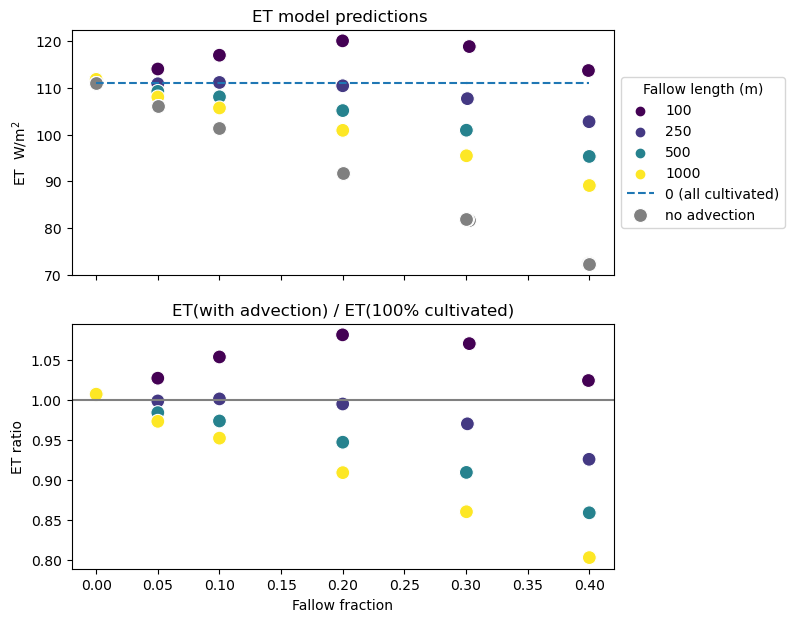

In [10]:

import seaborn as sns


fig,axes = plt.subplots(2,1, sharex = True, figsize = (7,7))
ax = axes[0]
sns.scatterplot(data = results_df, x = 'fallow_fraction', y = 'Flux_ADV', s= 100, ax = ax,
                palette = 'viridis', hue = 'fallow_length')
ax.plot( results_df.fallow_fraction , results_df.Flux_CC, '--',  c = 'C0', label = '0 (all cultivated)')
sns.scatterplot(data = results_df, x = 'fallow_fraction',  y = 'Flux_noADV', ax = ax,
                c = 'grey', label = 'no advection', 
                s= 100)
ax.set_ylabel("ET  W/m$^2$")
ax.set_xlabel("Fallow fraction")
ax.legend(title = 'Fallow length (m)', loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_ylim(0,)
ax.set_title("ET model predictions ")


ax = axes[1]
sns.scatterplot(data = results_df, x = 'fallow_fraction', y = 'ratio_CC', s= 100, ax = ax,
                palette = 'viridis', hue = 'fallow_length')


ax.axhline(1, c= 'grey')
ax.set_ylabel('ET ratio')
ax.set_xlabel("Fallow fraction")
ax.set_title("ET(with advection) / ET(100% cultivated)")
# ax.set_ylim(0,)
ax.legend(title = 'Fallow length (m)', loc='center left', bbox_to_anchor=(1, 0.5)).set_visible(False)


# ax = axes[2]
# sns.scatterplot(data = results_df, x = 'fallow_fraction',  y = 'ratio_noADV',  s= 100, ax = ax,
#                  palette = 'viridis', hue = 'fallow_length')

# # ax.plot( results_df.fallow_fraction , results_df.Flux_CC,  c = 'C0', label = 'no fallowing')

# ax.axhline(1, c= 'grey')
# ax.set_ylabel("ET ratio")
# ax.set_title("ET(with advection)/ ET(no advection)")
# ax.set_xlabel("Fallow fraction")
# ax.legend(title = 'Fallow length (m)', loc='center left', bbox_to_anchor=(1, 0.5)).set_visible(False)
# ax.axhline(1, c= 'grey')


Text(0.5, 0, 'Irrigated fraction')

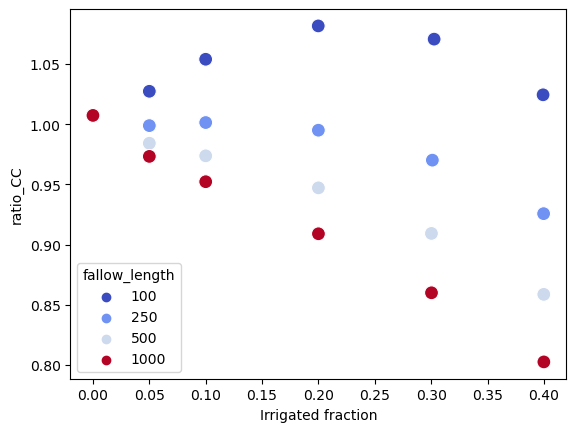

In [13]:
sns.scatterplot(data = results_df, x = 'fallow_fraction', y = 'ratio_CC', s = 100,
                palette = 'coolwarm', hue = 'fallow_length')
# plt.ylabel("Flux g/(s m2)")
plt.xlabel("Irrigated fraction")

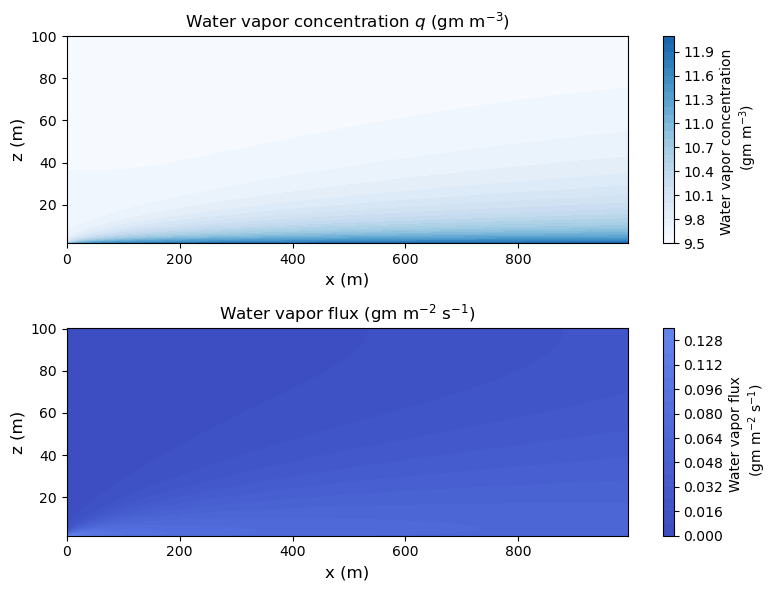

In [14]:
z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

nx = params['nx']
nz = params['nz']
dx = params['dx']
dz = params['dz']
k = params['k']
zom = params['zom']
ustar = params['ustar']
Q_f = params['Q_f']
Q_a = params['Q_a']
Q_c = params['Q_c']
Hmax = params['Hmax']
LE_f = ustar*k*(Q_f - Q_a)/np.log(Hmax/zom)
Qup_f = Q_f - LE_f/(k*ustar)*np.log(z/zom)
Qs_array = populate_Qc_array(params)
U = (ustar / k) * np.log(z / zom)

Q, FluxQ = varying_Qs(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Qs_array, Q_a)
Q_uniform, FluxQ_uniform = uniform_cultivated(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Q_c, Q_a)
Q_fallow, FluxQ_fallow = uniform_fallow(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Q_f, Q_a)        

# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

plt.subplot(2, 1, 1)
plt.contourf(x[:200], z[2:], (Q_uniform[:200, 2:].T), 25, cmap='Blues',  vmax = Q_c, vmin = Q_a)
plt.colorbar(label='Water vapor concentration \n (gm m$^{-3}$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

plt.subplot(2, 1, 2)
plt.contourf(x[:200], z[2:], FluxQ_uniform[:200, 2:].T.round(4),  20, cmap='coolwarm', vmin = 0, vmax = 1)
plt.colorbar(label='Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()



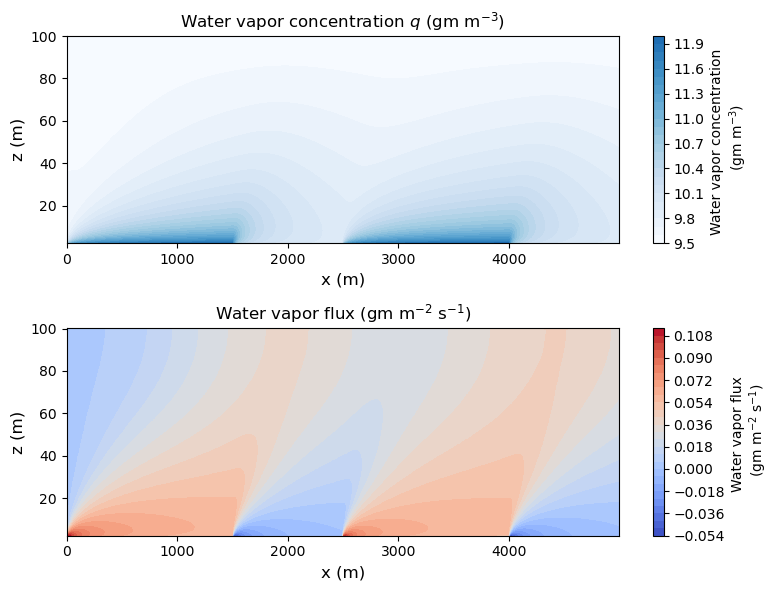

In [15]:
# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

plt.subplot(2, 1, 1)
plt.contourf(x[:1000], z[3:], (Q[:1000, 3:].T), 25, cmap='Blues',  vmax = Q_c, vmin = Q_a)
plt.colorbar(label='Water vapor concentration \n (gm m$^{-3}$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

plt.subplot(2, 1, 2)
plt.contourf(x[:1000], z[3:], FluxQ[:1000, 3:].T.round(4),  30, cmap='coolwarm')
plt.colorbar(label='Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()



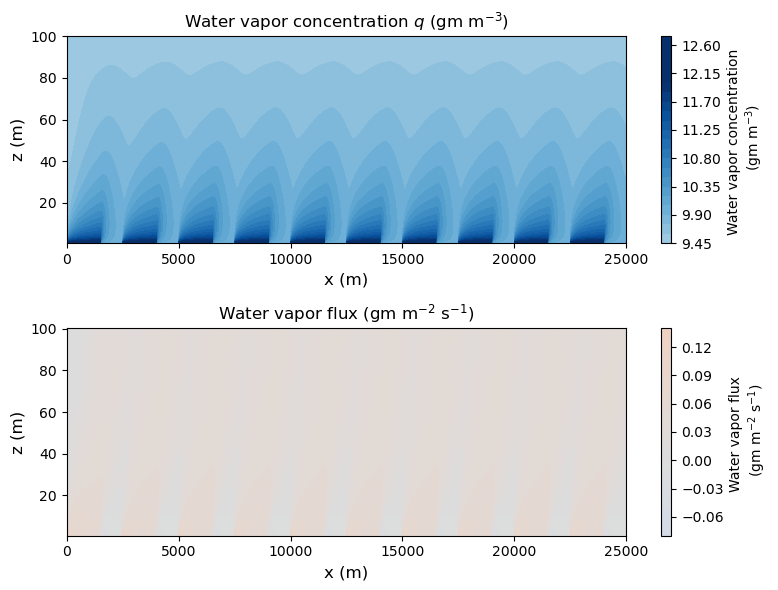

In [16]:
# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

# Normalized concentration (if needed)
# Qd = (Q - Qa) / (Qs - Qa)

plt.subplot(2, 1, 1)
plt.contourf(x, z, (Q.T), 25, cmap='Blues',  vmax = 12, vmin = 8)
plt.colorbar(label='Water vapor concentration \n (gm m$^{-3}$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

plt.subplot(2, 1, 2)
plt.contourf(x, z, FluxQ.T.round(4),  20, cmap='coolwarm', vmin = -1, vmax = 1)
plt.colorbar(label='Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)

plt.tight_layout()
plt.show()


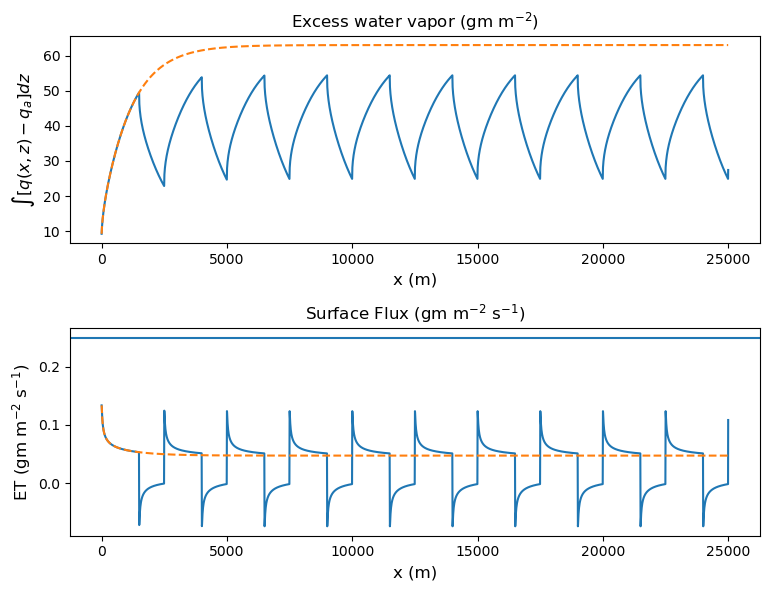

In [17]:
# Plot excess water vapor and surface flux
plt.figure(figsize = (8, 6))

QQ = np.sum(Q - Q_a, axis=1) * dz
QQ_uniform = np.sum(Q_uniform - Q_a, axis=1) * dz

plt.subplot(2, 1, 1)
plt.plot(x, QQ, '-')
plt.plot(x, QQ_uniform, '--')

plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel(r'$\int [q(x,z) - q_a]dz$', fontsize=12, fontweight='normal')
plt.title('Excess water vapor (gm m$^{-2}$)', fontsize=12)


plt.subplot(2, 1, 2)
plt.plot(x[1:], FluxQ[1:, 1], '-')
plt.plot(x[1:],  FluxQ_uniform[1:, 1], '--')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('ET (gm m$^{-2}$ s$^{-1}$)', fontsize=12, fontweight='normal')
plt.title('Surface Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()
plt.axhline(0.25)
# plt.ylim(0, )

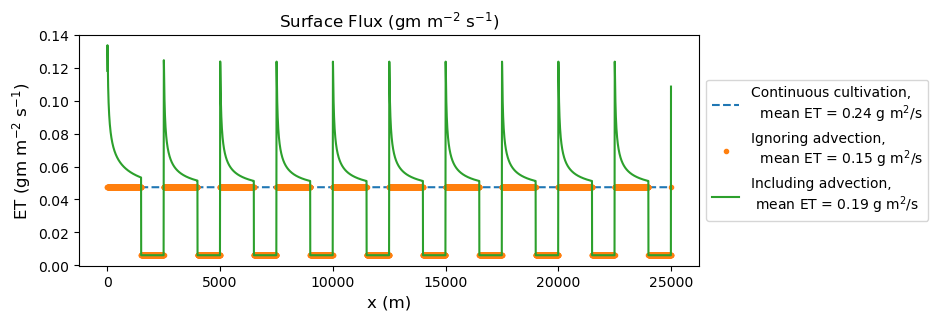

In [18]:
plt.figure(figsize = (8, 3))
ax = plt.gca()

plt.plot(x, np.ones(nx ) * FluxQ_uniform[nx-1, 0], '--',  
         label = "Continuous cultivation, \n  mean ET = {0:.2f} g m$^2$/s".format(
             FluxQ_uniform[nx-1, 0]*dx))

uniform_flux = FluxQ_uniform[nx-1, 0]*(Qs_array > Q_f).mean() + \
                FluxQ_fallow[nx-1, 0]*(Qs_array == Q_f).mean()
plt.plot(x, FluxQ_uniform[nx-1, 0]*(Qs_array > Q_f) + FluxQ_fallow[nx-1, 0]*(Qs_array == Q_f), '.',  label = "Ignoring advection, \n  mean ET = {0:.2f} g m$^2$/s".format(
    uniform_flux*dx))

FluxQ[Qs_array < Q_c] = FluxQ_fallow[-1,0]
plt.plot(x[:], FluxQ[:, 0], '-', label = "Including advection,  \n mean ET = {0:.2f} g m$^2$/s".format(
    FluxQ[:, 0].mean()*dx))

plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('ET (gm m$^{-2}$ s$^{-1}$)', fontsize=12, fontweight='normal')
plt.title('Surface Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# (FluxQ[:, 0].sum()*dx/nx - FluxQ[nx:,  0].sum()*dx)/(FluxQ[nx:,  0].sum()*dx)

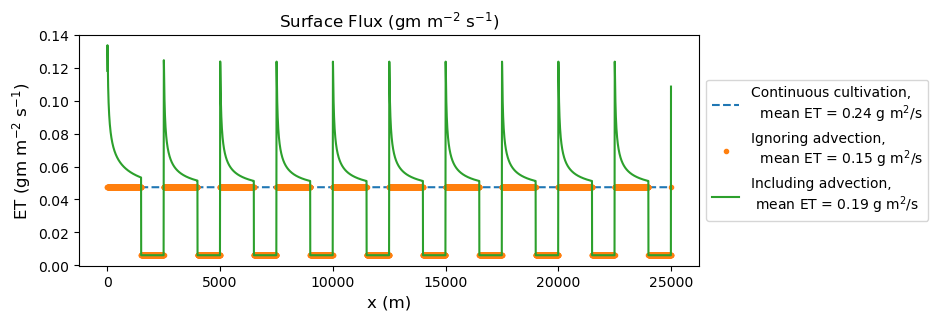

In [19]:
plt.figure(figsize = (8, 3))
ax = plt.gca()

plt.plot(x, np.ones(nx ) * FluxQ_uniform[nx-1, 0], '--',  
         label = "Continuous cultivation, \n  mean ET = {0:.2f} g m$^2$/s".format(
             FluxQ_uniform[nx-1, 0]*dx))

uniform_flux = FluxQ_uniform[nx-1, 0]*(Qs_array > Q_f).mean() + \
                FluxQ_fallow[nx-1, 0]*(Qs_array == Q_f).mean()
plt.plot(x, FluxQ_uniform[nx-1, 0]*(Qs_array > Q_f) + FluxQ_fallow[nx-1, 0]*(Qs_array == Q_f), '.',  label = "Ignoring advection, \n  mean ET = {0:.2f} g m$^2$/s".format(
    uniform_flux*dx))

FluxQ[Qs_array < Q_c] = FluxQ_fallow[-1,0]
plt.plot(x[:], FluxQ[:, 0], '-', label = "Including advection,  \n mean ET = {0:.2f} g m$^2$/s".format(
    FluxQ[:, 0].mean()*dx))

plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('ET (gm m$^{-2}$ s$^{-1}$)', fontsize=12, fontweight='normal')
plt.title('Surface Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# (FluxQ[:, 0].sum()*dx/nx - FluxQ[nx:,  0].sum()*dx)/(FluxQ[nx:,  0].sum()*dx)